In [391]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

In [392]:
OD = np.random.randint(100,10000, (10, 10, 9,2))
thresh = 200

## Building the data

Let's use the following conventions:
age groups (as in paper):
    - 0 to 9
    - 10 to 19
    - 20 to 29
    - 30 to 39
    - 40 to 49
    - 50 to 59
    - 60 to 69
    - 70 to 79
    - 80+
and further compartementalize according to sex.

All rates are therefore given as 2D arrays of shape (9, 2) where the first axis is the age group and the second the gender.

In [393]:
OD = OD.sum(axis=3).sum(axis=2)

In [394]:
def split_groups(N):
    split_points = np.random.choice(range(1,N), 9-1, replace = False)
    split_points.sort()
    age_groups = [split_points[0]]+[split_points[n]-split_points[n-1] for n in range(1,len(split_points))] + [N-split_points[-1]]
    groups = [[np.random.choice(range(g), 1), g] for g in age_groups]
    groups = [[int(a[0]),int(a[1]-a[0])] for a in groups]
    return np.array(groups)

In [395]:
# initialize the population vector from the origin-destination flow matrix
N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
locs_len = len(N_k)                      # number of locations
SIR = np.zeros(shape=(locs_len, 9, 2, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
for i in tqdm.tqdm_notebook(range(locs_len)):
    SIR[i,:,:,0] = split_groups(N_k[i])                      # initialize the S group with the respective populations

<ipython-input-395-862585e25305>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm.tqdm_notebook(range(locs_len)):


In [396]:
first_infections = np.where(SIR[:,:,:, 0]<=thresh, SIR[:,:,:, 0]//20, 0)   # for demo purposes, randomly introduce infections
SIR[:,:,:, 0] = SIR[:,:,:, 0] - first_infections
SIR[:,:,:, 1] = SIR[:,:,:, 1] + first_infections                           # move infections to the I group

In [390]:
  N_k = np.abs(np.diagonal(OD) + OD.sum(axis=0) - OD.sum(axis=1))
  locs_len = len(N_k)                 # number of locations
  SIR = np.zeros(shape=(locs_len, 3)) # make a numpy array with 3 columns for keeping track of the S, I, R groups
  SIR[:,0] = N_k                      # initialize the S group with the respective populations
  
  first_infections = np.where(SIR[:, 0]<=thresh, SIR[:, 0]//20, 0)   # for demo purposes, randomly introduce infections
  SIR[:, 0] = SIR[:, 0] - first_infections
  SIR[:, 1] = SIR[:, 1] + first_infections                           # move infections to the I group
  
  # row normalize the SIR matrix for keeping track of group proportions
  row_sums = SIR.sum(axis=1)
  SIR_n = SIR / row_sums[:, np.newaxis]

In [441]:
# row normalize the SIR matrix for keeping track of group proportions
row_sums = SIR.sum(axis=3).sum(axis=2).sum(axis=1)
SIR_n = SIR / row_sums[:, np.newaxis, np.newaxis, np.newaxis]

### initialize parameters

In [442]:
beta = np.full((9,2), 0.16)
gamma = np.full((9,2), 0.04)
public_trans = 0.5         # alpha
R0 = beta/gamma
beta_vec = np.random.gamma(beta, 1/gamma, (locs_len, 9, 2))
gamma_vec = np.full((locs_len, 9, 2), gamma)
public_trans_vec = np.full((locs_len, 9, 2), public_trans)

In [443]:
# make copy of the SIR matrices 
SIR_sim = SIR.copy()
SIR_nsim = SIR_n.copy()

In [450]:
infected_mat.shape

(10, 10, 9, 2)

In [461]:
OD_infected.shape

(10, 10, 9, 2)

In [452]:
OD.shape

(10, 10)

In [462]:
inflow_infected.shape

(10, 10, 2)

In [466]:
N_k.shape

(10,)

In [467]:
OD.sum(axis=0).shape

(10,)

In [468]:
inflow_infected/(N_k + OD.sum(axis=0))

ValueError: operands could not be broadcast together with shapes (10,9,2) (10,) 

In [469]:
beta_vec.shape

(10, 9, 2)

In [473]:
SIR_sim[:,:,:,0].shape

(10, 9, 2)

In [477]:
inflow_infected.shape

(10, 9, 2)

In [489]:
# run model
print(SIR_sim.sum(axis=0).sum() == N_k.sum())
infected_pop_norm = []
susceptible_pop_norm = []
recovered_pop_norm = []
for time_step in tqdm.tqdm_notebook(range(100)):
  infected_mat = np.array([SIR_nsim[:,:,:,1],]*locs_len)#.transpose()
  OD_infected = np.round(OD[:,:,np.newaxis, np.newaxis]*infected_mat)
  inflow_infected = OD_infected.sum(axis=1)
  inflow_infected = np.round(inflow_infected * public_trans_vec)
  print('total infected inflow: ', inflow_infected.sum())
  new_infect = beta_vec*SIR_sim[:,:,:, 0]*inflow_infected/(N_k + OD.sum(axis=0))[:,np.newaxis, np.newaxis]
  new_recovered = gamma_vec*SIR_sim[:,:,:, 1]
  new_infect = np.where(new_infect>SIR_sim[:,:,:, 0], SIR_sim[:,:,:, 0], new_infect)
  SIR_sim[:,:,:, 0] = SIR_sim[:,:,:, 0] - new_infect
  SIR_sim[:,:,:, 1] = SIR_sim[:,:,:, 1] + new_infect - new_recovered
  SIR_sim[:,:,:, 2] = SIR_sim[:,:,:, 2] + new_recovered
  SIR_sim = np.where(SIR_sim<0,0,SIR_sim)
  # recompute the normalized SIR matrix
  row_sums = SIR_sim.sum(axis=3).sum(axis=2).sum(axis=1)
  SIR_nsim = SIR_sim / row_sums[:, np.newaxis, np.newaxis, np.newaxis]
  S = SIR_sim[:,:,:,0].sum()/N_k.sum()
  I = SIR_sim[:,:,:,1].sum()/N_k.sum()
  R = SIR_sim[:,:,:,2].sum()/N_k.sum()
  print(S, I, R, (S+I+R)*N_k.sum(), N_k.sum())
  print('\n')
  infected_pop_norm.append(I)
  susceptible_pop_norm.append(S)
  recovered_pop_norm.append(R)

True


<ipython-input-489-ec4de80fdb1e>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for time_step in tqdm.tqdm_notebook(range(100)):


total infected inflow:  1545.0
0.7321296282567383 0.00037558672234114476 0.26749478502092056 936232.0 936232


total infected inflow:  1482.0
0.7321295161956622 0.00036067531452353295 0.26750980848981415 936232.0 936232


total infected inflow:  1422.0
0.7321294082214448 0.0003463562761599458 0.2675242355023951 936231.9999999999 936232


total infected inflow:  1365.0
0.7321293059278794 0.0003326043186790977 0.26753808975344157 936232.0 936232


total infected inflow:  1311.0
0.7321292066103873 0.0003193994634239955 0.2675513939261887 936232.0 936232


total infected inflow:  1262.0
0.7321291136557586 0.0003067164395155653 0.26756416990472565 936231.9999999998 936232


total infected inflow:  1212.0
0.7321290222494191 0.00029453918827449264 0.2675764385623063 936231.9999999999 936232


total infected inflow:  1164.0
0.7321289339950826 0.0002828458750800564 0.26758822012983724 936232.0 936232


total infected inflow:  1112.0
0.7321288511123781 0.0002716149227813999 0.2675995339648405 93

In [490]:
inflow_infected.T.shape

(2, 9, 10)

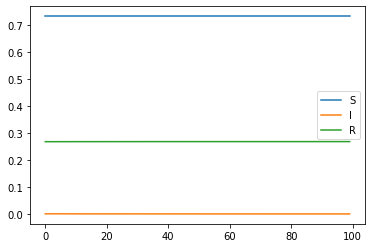

In [491]:
plt.plot(susceptible_pop_norm, label='S')
plt.plot(infected_pop_norm, label='I')
plt.plot(recovered_pop_norm, label='R')
plt.legend();